<h1><center>How to export 🤗 Transformers Models to ONNX ?<h1><center>

[ONNX](http://onnx.ai/) is open format for machine learning models. It allows to save your neural network's computation graph in a framework agnostic way, which might be particulary helpful when deploying deep learning models.

Indeed, businesses might have other requirements _(languages, hardware, ...)_ for which the training framework might not be the best suited in inference scenarios. In that context, having a representation of the actual computation graph that can be shared accross various business units and logics across an organization might be a desirable component.

Along with the serialization format, ONNX also provides a runtime library which allows efficient and hardware specific execution of the ONNX graph. This is done through the [onnxruntime](https://microsoft.github.io/onnxruntime/) project and already includes collaborations with many hardware vendors to seamlessly deploy models on various platforms.

Through this notebook we'll walk you through the process to convert a PyTorch or TensorFlow transformers model to the [ONNX](http://onnx.ai/) and leverage [onnxruntime](https://microsoft.github.io/onnxruntime/) to run inference tasks on models from  🤗 __transformers__

## Exporting 🤗 transformers model to ONNX

---

Exporting models _(either PyTorch or TensorFlow)_ is easily achieved through the conversion tool provided as part of 🤗 __transformers__ repository. 

Under the hood the process is sensibly the following: 

1. Allocate the model from transformers (**PyTorch or TensorFlow**)
2. Forward dummy inputs through the model this way **ONNX** can record the set of operations executed
3. Optionally define dynamic axes on input and output tensors
4. Save the graph along with the network parameters

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers

In [7]:
from argparse import ArgumentParser
from os import listdir, makedirs
from os.path import abspath, dirname, exists
from typing import Dict, List, Optional, Tuple

from transformers import is_tf_available, is_torch_available
from transformers.pipelines import Pipeline, pipeline
from transformers.tokenization_utils import BatchEncoding

def load_graph_from_args(framework: str, model: str, tokenizer: Optional[str] = None) -> Pipeline:
    # If no tokenizer provided
    if tokenizer is None:
        tokenizer = model

    print("Loading pipeline (model: {}, tokenizer: {})".format(model, tokenizer))

    # Allocate tokenizer and model
    return pipeline("feature-extraction", model=model, tokenizer=tokenizer, framework=framework)


def infer_shapes(nlp: Pipeline, framework: str) -> Tuple[List[str], List[str], Dict, BatchEncoding]:
    def build_shape_dict(tensor, is_input: bool, seq_len: int):
        if isinstance(tensor, (tuple, list)):
            return [build_shape_dict(t, is_input, seq_len) for t in tensor]

        else:
            # Let's assume batch is the first axis with only 1 element (~~ might not be always true ...)
            axes = {[axis for axis, numel in enumerate(tensor.shape) if numel == 1][0]: "batch"}
            if is_input:
                if len(tensor.shape) == 2:
                    axes[1] = "sequence"
                else:
                    raise ValueError("Unable to infer tensor axes ({})".format(len(tensor.shape)))
            else:
                seq_axes = [dim for dim, shape in enumerate(tensor.shape) if shape == seq_len]
                axes.update({dim: "sequence" for dim in seq_axes})

        return axes

    tokens = nlp.tokenizer.encode_plus("This is a sample output", return_tensors=framework)
    seq_len = tokens.input_ids.shape[-1]
    outputs = nlp.model(**tokens) if framework == "pt" else nlp.model(tokens)

    if not isinstance(outputs, (list, tuple)):
        outputs = (outputs,)

    # Generate input names & axes
    input_vars = list(tokens.keys())
    input_dynamic_axes = {k: build_shape_dict(v, True, seq_len) for k, v in tokens.items()}

    # flatten potentially grouped outputs (past for gpt2, attentions)
    outputs_flat = []
    for output in outputs:
        if isinstance(output, (tuple, list)):
            outputs_flat.extend(output)
        else:
            outputs_flat.append(output)

    # Generate output names & axes
    output_names = ["output_{}".format(i) for i in range(len(outputs_flat))]
    output_dynamic_axes = {k: build_shape_dict(v, False, seq_len) for k, v in zip(output_names, outputs_flat)}

    # Create the aggregated axes representation
    dynamic_axes = dict(input_dynamic_axes, **output_dynamic_axes)
    return input_vars, output_names, dynamic_axes, tokens


def ensure_valid_input(model, tokens, input_names):
    """
    Ensure input are presented in the correct order, without any None
    Args:
        model: The model used to forward the input data
        tokens: BatchEncoding holding the input data
        input_names: The name of the inputs
    Returns: Tuple
    """
    model_args_name = model.forward.__code__.co_varnames

    ordered_input_names = []
    model_args = []
    for arg_name in model_args_name[1:]:  # start at index 1 to skip "self" argument
        if arg_name in input_names:
            ordered_input_names.append(arg_name)
            model_args.append(tokens[arg_name])
        else:
            break

    return ordered_input_names, tuple(model_args)

def convert(
    framework: str,
    model: str,
    output: str,
    opset: int,
    tokenizer: Optional[str] = None,
    use_external_format: bool = False,
):
    print("ONNX opset version set to: {}".format(opset))

    # Load the pipeline
    nlp = load_graph_from_args(framework, model, tokenizer)

    parent = dirname(output)
    if not exists(parent):
        print("Creating folder {}".format(parent))
        makedirs(parent)
    elif len(listdir(parent)) > 0:
        raise Exception("Folder {} is not empty, aborting conversion".format(parent))

    # Export the graph
    if framework == "pt":
        convert_pytorch(nlp, opset, output, use_external_format)
    else:
        convert_tensorflow(nlp, opset, output)


def convert_pytorch(nlp: Pipeline, opset: int, output: str, use_external_format: bool):
    if not is_torch_available():
        raise Exception("Cannot convert because PyTorch is not installed. Please install torch first.")

    import torch
    from torch.onnx import export

    print("PyTorch: {}".format(torch.__version__))

    with torch.no_grad():
        input_names, output_names, dynamic_axes, tokens = infer_shapes(nlp, "pt")
        ordered_input_names, model_args = ensure_valid_input(nlp.model, tokens, input_names)

        export(
            nlp.model,
            model_args,
            f=output,
            input_names=ordered_input_names,
            output_names=output_names,
            dynamic_axes=dynamic_axes,
            do_constant_folding=True,
#             use_external_data_format=use_external_format,
#             enable_onnx_checker=True,
            opset_version=opset,
        )

In [8]:
# !rm -rf onnx/
# from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", 
        model="/scratch/da2734/twitter/jobs/training_binary/simple_transformers_manu_bertbase/is_hired_1mo/", 
        output="/scratch/da2734/twitter/jobs/onnx/converted_model_tests/slow.onnx", 
        opset=11)

# Tensorflow 
# convert(framework="tf", model="bert-base-cased", output="onnx/bert-base-cased.onnx", opset=11)

ONNX opset version set to: 11
Loading pipeline (model: /scratch/da2734/twitter/jobs/training_binary/simple_transformers_manu_bertbase/is_hired_1mo/, tokenizer: /scratch/da2734/twitter/jobs/training_binary/simple_transformers_manu_bertbase/is_hired_1mo/)
PyTorch: 1.4.0


## How to leverage runtime for inference over an ONNX graph

---

As mentionned in the introduction, **ONNX** is a serialization format and many side projects can load the saved graph and run the actual computations from it. Here, we'll focus on the official [onnxruntime](https://microsoft.github.io/onnxruntime/). The runtime is implemented in C++ for performance reasons and provides API/Bindings for C++, C, C#, Java and Python.

In the case of this notebook, we will use the Python API to highlight how to load a serialized **ONNX** graph and run inference workload on various backends through **onnxruntime**.

**onnxruntime** is available on pypi:

- onnxruntime: ONNX + MLAS (Microsoft Linear Algebra Subprograms)
- onnxruntime-gpu: ONNX + MLAS + CUDA


In [ ]:
!pip install transformers onnxruntime-gpu onnx psutil matplotlib

## Preparing for an Inference Session

---

Inference is done using a specific backend definition which turns on hardware specific optimizations of the graph. 

Optimizations are basically of three kinds: 

- **Constant Folding**: Convert static variables to constants in the graph 
- **Deadcode Elimination**: Remove nodes never accessed in the graph
- **Operator Fusing**: Merge multiple instruction into one (Linear -> ReLU can be fused to be LinearReLU)

ONNX Runtime automatically applies most optimizations by setting specific `SessionOptions`.

Note:Some of the latest optimizations that are not yet integrated into ONNX Runtime are available in [optimization script](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/transformers) that tunes models for the best performance.

In [ ]:
# # An optional step unless
# # you want to get a model with mixed precision for perf accelartion on newer GPU
# # or you are working with Tensorflow(tf.keras) models or pytorch models other than bert

# !pip install onnxruntime-tools
# from onnxruntime_tools import optimizer

# # Mixed precision conversion for bert-base-cased model converted from Pytorch
# optimized_model = optimizer.optimize_model("bert-base-cased.onnx", model_type='bert', num_heads=12, hidden_size=768)
# optimized_model.convert_model_float32_to_float16()
# optimized_model.save_model_to_file("bert-base-cased.onnx")

# # optimizations for bert-base-cased model converted from Tensorflow(tf.keras)
# optimized_model = optimizer.optimize_model("bert-base-cased.onnx", model_type='bert_keras', num_heads=12, hidden_size=768)
# optimized_model.save_model_to_file("bert-base-cased.onnx")


In [9]:
from os import environ
from psutil import cpu_count

# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

from onnxruntime import InferenceSession, SessionOptions, get_all_providers

In [10]:
def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties than might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1

  # Load the model as a graph and prepare the CPU backend 
  return InferenceSession(model_path, options, providers=[provider])

## Forwarding through our optimized ONNX model running on CPU

---

When the model is loaded for inference over a specific provider, for instance **CPUExecutionProvider** as above, an optimized graph can be saved. This graph will might include various optimizations, and you might be able to see some **higher-level** operations in the graph _(through [Netron](https://github.com/lutzroeder/Netron) for instance)_ such as:
- **EmbedLayerNormalization**
- **Attention**
- **FastGeLU**

These operations are an example of the kind of optimization **onnxruntime** is doing, for instance here gathering multiple operations into bigger one _(Operator Fusing)_.

In [12]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
cpu_model = create_model_for_provider("/scratch/da2734/twitter/jobs/onnx/converted_model_tests/slow.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer.encode_plus("My name is Bert", return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Run the model (None = get all the outputs)
sequence, pooled = cpu_model.run(None, inputs_onnx)

# Print information about outputs

print(f"Sequence output: {sequence.shape}, Pooled output: {pooled.shape}")

Sequence output: (1, 6, 768), Pooled output: (1, 768)


## Benchmarking different CPU & GPU providers

_**Disclamer: results may vary from the actual hardware used to run the model**_

In [14]:
from torch.cuda import get_device_name
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

print(f"Doing GPU inference on {get_device_name(0)}", flush=True)

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str


# All the providers we'll be using in the test
results = {}
providers = [
  "CUDAExecutionProvider",
  "CPUExecutionProvider",            
  "TensorrtExecutionProvider",
  "DnnlExecutionProvider",          
]

# Iterate over all the providers
for provider in providers:

  # Create the model with the specified provider
  model = create_model_for_provider("/scratch/da2734/twitter/jobs/onnx/converted_model_tests/slow.onnx", provider)

  # Keep track of the inference time
  time_buffer = []

  # Warm up the model
  for _ in trange(10, desc="Warming up"):
    model.run(None, inputs_onnx)

  # Compute 
  for _ in trange(100, desc=f"Tracking inference time on {provider}"):
    with track_infer_time(time_buffer):
      model.run(None, inputs_onnx)

  # Store the result
  results[provider] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
  )

Doing GPU inference on Tesla P40


Warming up: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s]
Tracking inference time on TensorrtExecutionProvider: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]
Tracking inference time on DnnlExecutionProvider: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


In [15]:
from transformers import BertModel

# Add PyTorch to the providers
model_pt = BertModel.from_pretrained("bert-base-cased")
for _ in trange(10, desc="Warming up"):
  model_pt(**model_inputs)

# Compute 
time_buffer = []
for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
  with track_infer_time(time_buffer):
    model_pt(**model_inputs)

# Store the result
results["Pytorch"] = OnnxInferenceResult(
    time_buffer, 
    model.get_session_options().optimized_model_filepath
) 

Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


In [17]:
model.get_session_options().optimized_model_filepath

''

## Show the inference performance of each providers 

_Note: PyTorch model benchmark is run on CPU_

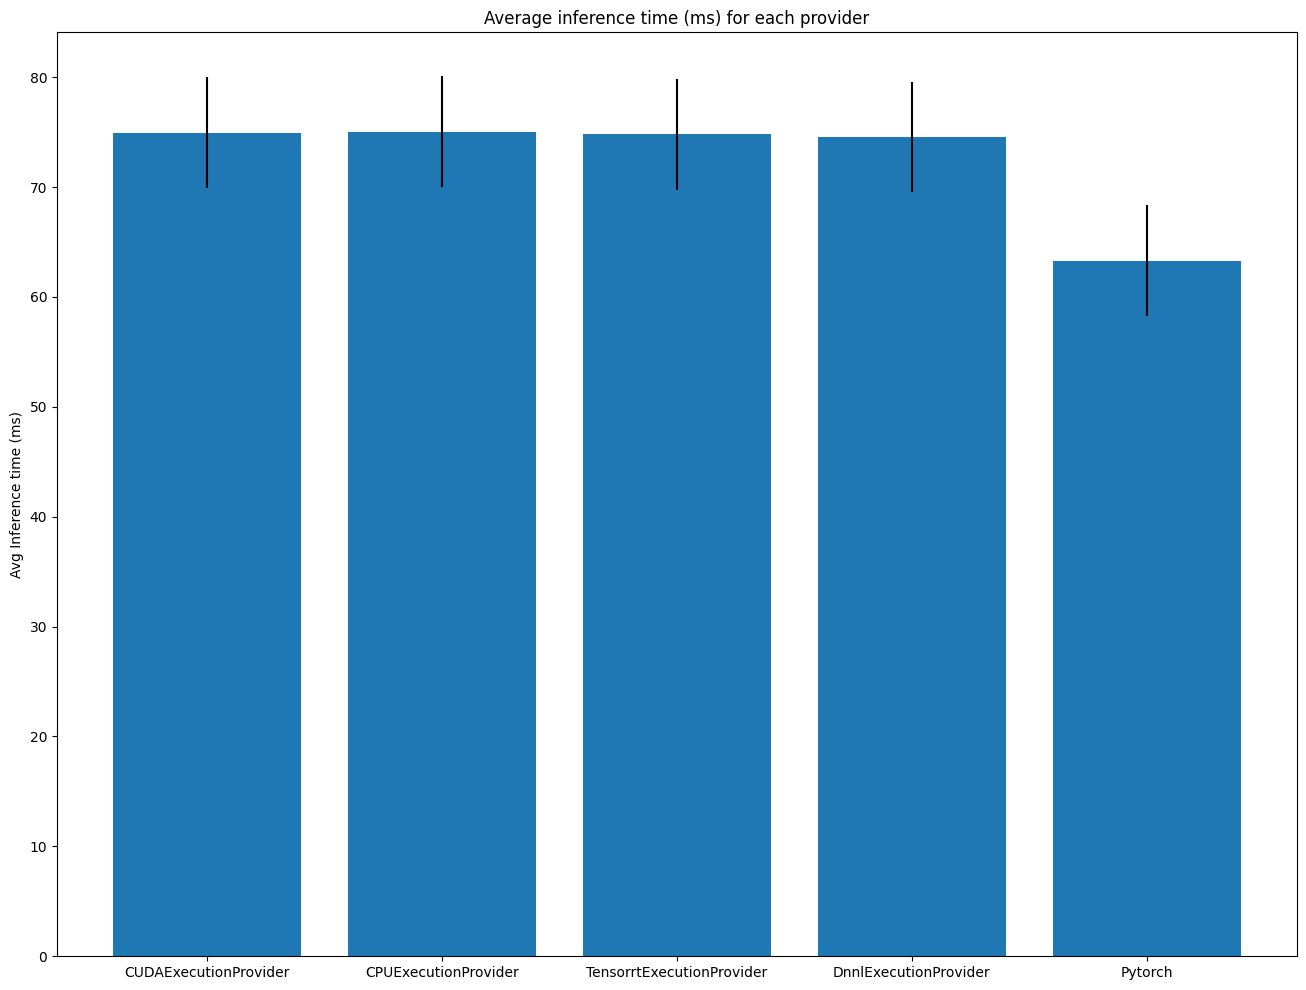

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()